In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from torch import Tensor

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length - 11
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length],dtype=torch.float32)
        y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10],dtype=torch.float32)
        return x, y


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.d_model = d_model

    def forward(self, x: Tensor, indices = None) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_length, embedding_dim]
        """
        if indices is None:
            x += self.pe[:x.size(1)]
            return self.dropout(x)
        else:
            div_term = torch.exp(torch.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
            x[:,:, 0::2] += torch.sin(indices * div_term.unsqueeze(0))
            x[:,:, 1::2] += torch.cos(indices * div_term.unsqueeze(0))
            return x


class TransformerForecaster(nn.Module):
    def __init__(self, seq_length, input_dim, output_dim, d_model=64, nhead=4, num_layers=2):
        super(TransformerForecaster, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers

        self.norm = torch.nn.BatchNorm1d(3)
        
        self.embedding = nn.Linear(input_dim, d_model)

        self.positional_encoding = PositionalEncoding(
           d_model=int(d_model),
           dropout=0,
           max_len=100
        )

        self.positional_encoding1 = PositionalEncoding(
            d_model=int(d_model/2),
            dropout=0,
            max_len=100
        )

        self.positional_encoding2 = PositionalEncoding(
            d_model=int(d_model/2),
            dropout=0,
            max_len=100
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,dropout=0,batch_first=True),
            num_layers=num_layers)
        
        #self.linear = nn.Linear(seq_length * d_model, output_dim)
        self.linear = nn.Linear(30 * d_model, output_dim)
    
    def forward(self, x):
        x_original = x
        #print(x.shape)
        x = torch.flatten(x,end_dim=1)
        x = self.norm(x)
        x = torch.reshape(x,x_original.shape)
        x = self.embedding(x)
        #x = x.permute(1, 0, 2)  # transpose to (seq_length, batch_size, d_model)
        #x[:,:,:int(self.d_model/2)] = self.positional_encoding1(x[:,:,:int(self.d_model/2)])
        #x[:,:,int(self.d_model/2):] = self.positional_encoding2(x[:,:,int(self.d_model/2):],indices=x_original[:,:,2].unsqueeze(-1))
        #indices = x_original[:,:,2].unsqueeze(-1)
        #x = self.positional_encoding(x,indices=indices)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x


In [2]:
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length - 11
    
    def __getitem__(self, idx):
        a = torch.tensor(self.data[idx:idx+self.seq_length+10],dtype=torch.float32)
        b = torch.tensor(np.cumsum([i[1] for i in self.data[idx:idx+self.seq_length+10]]),dtype=torch.float32)
        x = torch.cat((a,b.unsqueeze(1)),dim=1)
        x[self.seq_length:,0] = 0
        y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10,0],dtype=torch.float32)
        return x, y

In [3]:
import random

train_x = []

for i in range(12000):
    if random.random() < 0.5:
        if len(train_x):
            train_x.append([np.sin(0.0943*i),i-old_i])
            old_i = i
        else:
            train_x.append([np.sin(0.0943*i),1])
            old_i = i

train_x = torch.tensor(train_x,dtype=torch.float32)

In [4]:

seq_length = 20

dataset = TimeSeriesDataset(train_x, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = TransformerForecaster(seq_length, 3, 10,num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=100)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

print("Number of trainable parameters:",sum(p.numel() for p in model.parameters()))

num_epochs = 100
for epoch in range(num_epochs):
    losses = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_pred = model(x)
        #print(x.shape)
        #print(y_pred.shape,y.shape)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch:', epoch+1, 'Loss:', np.mean(losses),scheduler.get_last_lr())
    scheduler.step()

Number of trainable parameters: 581776


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/1366622062.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(self.data[idx:idx+self.seq_length+10],dtype=torch.float32)
/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/1366622062.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10,0],dtype=torch.float32)


Epoch: 1 Loss: 0.1695492480029451 [0.0001]
Epoch: 2 Loss: 0.07636127077994194 [9.901e-05]
Epoch: 3 Loss: 0.047844007888689956 [9.802e-05]
Epoch: 4 Loss: 0.031613050742035215 [9.703e-05]
Epoch: 5 Loss: 0.021508755063281416 [9.604e-05]
Epoch: 6 Loss: 0.015872263567561797 [9.504999999999999e-05]
Epoch: 7 Loss: 0.013048269667048404 [9.405999999999999e-05]
Epoch: 8 Loss: 0.010670931078493595 [9.306999999999999e-05]
Epoch: 9 Loss: 0.008816203186684784 [9.207999999999999e-05]
Epoch: 10 Loss: 0.0067085244772123525 [9.108999999999998e-05]
Epoch: 11 Loss: 0.0068803849491350195 [9.009999999999998e-05]
Epoch: 12 Loss: 0.005387442929551322 [8.910999999999998e-05]
Epoch: 13 Loss: 0.0050595541796746085 [8.811999999999998e-05]
Epoch: 14 Loss: 0.005289227624939001 [8.712999999999997e-05]
Epoch: 15 Loss: 0.004502781047584846 [8.613999999999997e-05]
Epoch: 16 Loss: 0.006142062031010047 [8.514999999999998e-05]
Epoch: 17 Loss: 0.004456006615927958 [8.415999999999998e-05]
Epoch: 18 Loss: 0.00367895024952458

In [5]:
test_x = []

for i in range(300):
    if random.random() < 0.5:
        if len(test_x):
            test_x.append([np.sin(0.0943*i + 566),i-old_i])
            old_i = i
        else:
            test_x.append([np.sin(0.0943*i + 566),1])
            old_i = i

test_x = torch.tensor(test_x,dtype=torch.float32)

torch.Size([1, 30, 3])


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/2747675177.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(test_x[k:k+30],dtype=torch.float32)
/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/2747675177.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_x[k+20:k+30,0],dtype=torch.float32)


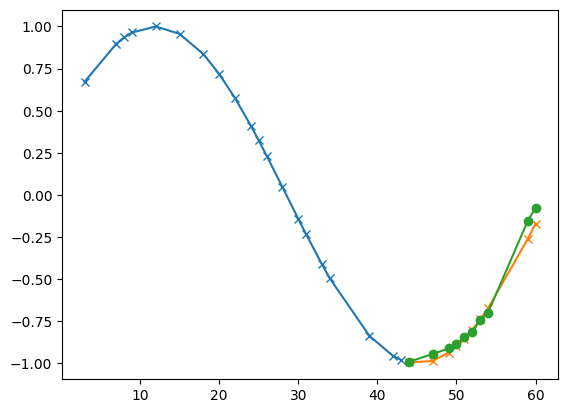

In [6]:
k = random.randint(0,50)

a = torch.tensor(test_x[k:k+30],dtype=torch.float32)
b = torch.tensor(np.cumsum([i[1] for i in test_x[k:k+30]]),dtype=torch.float32)
sample = torch.cat((a,b.unsqueeze(1)),dim=1).unsqueeze(0)
y = sample[:,20:,0]
sample[:,20:,0] = 0

y = torch.tensor(test_x[k+20:k+30,0],dtype=torch.float32)

print(sample.shape)

pred_y = model(sample)

import matplotlib.pyplot as plt

# plt.plot(torch.cumsum(sample[0,:,1],dim=0),sample[0,:,0],"x")
# plt.plot(torch.cumsum(sample[0,:,1],dim=0)[20:],pred_y[0].tolist(),"o")

plt.plot(sample[0,:20,2],sample[0,:20,0],"-x")
plt.plot(sample[0,20:,2],y,"-x")
plt.plot(sample[0,20:,2],pred_y[0].tolist(),"-o")

/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/1366622062.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(self.data[idx:idx+self.seq_length+10],dtype=torch.float32)
/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_93305/1366622062.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10,0],dtype=torch.float32)


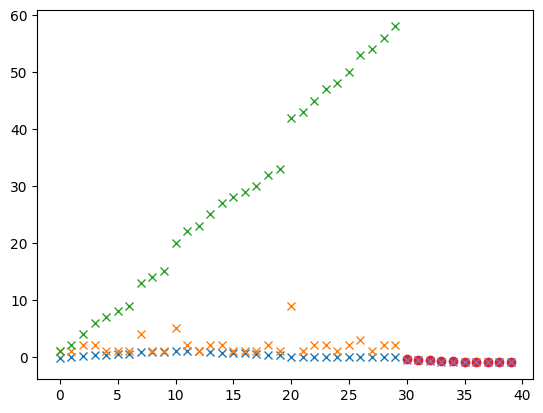

In [7]:
# Example usage
import numpy as np

test_x = [[np.sin(0.0543*i) for i in range(2800,2800 + seq_length)]]

test_x = torch.tensor(test_x,dtype=torch.float32)

for x,y in dataloader:
    pred_y = model(x)

import matplotlib.pyplot as plt

plt.plot(list(range(len(x[0]))),x[0],"x")
plt.plot(list(range(len(x[0]),len(x[0])+ len(pred_y[0]))),pred_y[0].tolist(),"o")
plt.plot(list(range(len(x[0]),len(x[0])+ len(pred_y[0]))),y[0].tolist(),"x")


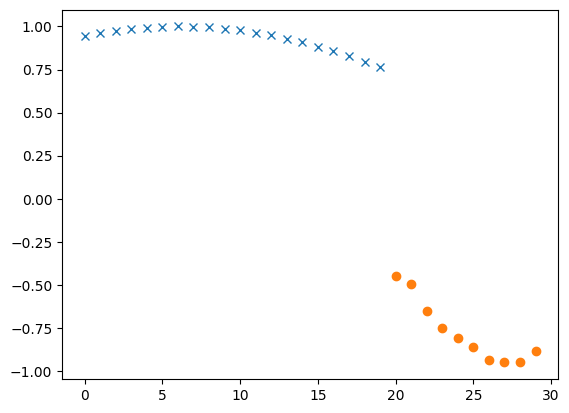

In [8]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(test_x[0]))),test_x[0],"x")
plt.plot(list(range(len(test_x[0]),len(test_x[0])+ len(pred_y[0]))),pred_y[0].tolist(),"o")

In [9]:
test_x.shape

torch.Size([1, 20])

In [10]:
a = torch.tensor([[1,2],[4,5],[7,8]])
b = torch.tensor([[1,1],[0,1],[0,1]])

a += torch.tensor([1,2])

a


tensor([[ 2,  4],
        [ 5,  7],
        [ 8, 10]])

In [11]:
a.flatten()
b.flatten()

tensor([1, 1, 0, 1, 0, 1])

In [12]:
import numpy as np
b = np.array([[1,1],[0,1],[0,1]])
np.any(b)

True

In [13]:
a.flatten()[torch.nonzero(b.flatten())].flatten()

TypeError: nonzero(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
indices = torch.tensor([[0,1,2,3],[4,5,6,7]]).unsqueeze(-1)

div_term = torch.exp(torch.arange(0, 64, 2) * (-math.log(10000.0) / 64))
pe = torch.zeros(2,4, 64)
pe[:,:, 0::2] = torch.sin(indices * div_term.unsqueeze(0))
pe[:,:, 1::2] = torch.cos(indices * div_term.unsqueeze(0))

pe.shape

torch.Size([2, 4, 64])

In [ ]:
print(indices.shape,div_term.unsqueeze(0).shape)

torch.Size([2, 4, 1]) torch.Size([1, 32])
